<a href="https://colab.research.google.com/github/fjadidi2001/Image_Inpaint/blob/main/FastInpaint_Jan14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
!pip install datasets


import os
import glob
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
from google.colab import drive
import torchvision.datasets as datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
# Download latest version
path = kagglehub.dataset_download("jessicali9530/caltech256")
print("Path to dataset files:", path)

100%|██████████| 2.12G/2.12G [00:17<00:00, 133MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jessicali9530/caltech256/versions/2


In [4]:
# Model name and setup
model_name = "caltech256-fastInpaint"
drive.mount('/content/drive')
CHECKPOINTS_DIR = '/content/drive/MyDrive/ckpts'

Mounted at /content/drive


In [5]:
def setup_data(img_size=256, batch_size=8):
    """Setup data loaders for Caltech256"""
    # Download dataset
    base_path = kagglehub.dataset_download("jessicali9530/caltech256")
    image_dir = os.path.join(base_path, '256_ObjectCategories')

    print(f"Base path: {base_path}")
    print(f"Image directory: {image_dir}")

    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Create dataset
    dataset = datasets.ImageFolder(root=image_dir, transform=transform)
    print(f"\nLoaded dataset with {len(dataset)} images")

    # Split dataset
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    # Create splits
    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size]
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        num_workers=2
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=2
    )

    print(f"Train size: {len(train_dataset)}")
    print(f"Val size: {len(val_dataset)}")
    print(f"Test size: {len(test_dataset)}")

    return train_loader, val_loader, test_loader


In [6]:
def visualize_batch(original_images, masked_images, outputs, epoch, batch_idx, save_dir='visualization'):
    """Visualize a batch of images: original, masked, and reconstructed"""
    os.makedirs(save_dir, exist_ok=True)

    # Convert tensors to numpy arrays and move to CPU if needed
    original_images = original_images.cpu().detach().numpy()
    masked_images = masked_images.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()

    # Create a figure with three rows: original, masked, and reconstructed
    fig, axes = plt.subplots(3, min(4, original_images.shape[0]), figsize=(15, 10))

    for i in range(min(4, original_images.shape[0])):
        # Original
        axes[0, i].imshow(np.transpose(original_images[i], (1, 2, 0)) * 0.5 + 0.5)
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original')

        # Masked
        axes[1, i].imshow(np.transpose(masked_images[i], (1, 2, 0)) * 0.5 + 0.5)
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Masked')

        # Reconstructed
        axes[2, i].imshow(np.transpose(outputs[i], (1, 2, 0)) * 0.5 + 0.5)
        axes[2, i].axis('off')
        if i == 0:
            axes[2, i].set_title('Reconstructed')

    plt.tight_layout()
    plt.savefig(f'{save_dir}/epoch_{epoch}_batch_{batch_idx}.png')
    plt.close()

In [7]:
def visualize_sample_batch(data_loader, save_path='sample_batch.png'):
    """Visualize and save a sample batch of images"""
    # Get a batch of images
    images = next(iter(data_loader))[0]  # [0] because ImageFolder returns (images, labels)

    # Create figure
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()

    for idx, img in enumerate(images[:8]):  # Show first 8 images
        # Convert tensor to numpy and denormalize
        img_np = img.numpy().transpose(1, 2, 0) * 0.5 + 0.5
        axes[idx].imshow(img_np)
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()
    print(f"Sample batch visualization saved to {save_path}")

In [8]:
def save_checkpoint(model, optimizer, epoch):
    os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
    checkpoint_path = f'{CHECKPOINTS_DIR}/{model_name}.pth'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_path)
    print(f"Checkpoint saved for {model_name} at epoch {epoch}")

In [9]:
def load_checkpoint(model, optimizer):
    ckpt_path = f'{CHECKPOINTS_DIR}/{model_name}.pth'
    if not os.path.exists(ckpt_path):
        print(f"No checkpoint found for {model_name}, starting from epoch 0")
        return 0

    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Checkpoint loaded for {model_name}, resuming from epoch {start_epoch}")
    return start_epoch

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm1 = nn.InstanceNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm2 = nn.InstanceNorm2d(channels)

    def forward(self, x):
        residual = x
        x = F.relu(self.norm1(self.conv1(x)))
        x = self.norm2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x

In [11]:
class InpaintingNet(nn.Module):
    def __init__(self):
        super(InpaintingNet, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(6, 64, 7, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # Middle blocks
        self.middle = nn.Sequential(*[ResidualBlock(256) for _ in range(6)])

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 3, 7, padding=3),
            nn.Tanh()
        )

    def forward(self, x, mask):
        x = torch.cat([x, mask], dim=1)
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x


In [12]:
def create_random_mask(image):
    """Create random rectangular masks"""
    batch_size, _, height, width = image.shape
    mask = torch.ones_like(image)

    for i in range(batch_size):
        h = torch.randint(height//4, height//2, (1,)).item()
        w = torch.randint(width//4, width//2, (1,)).item()

        top = torch.randint(0, height - h, (1,)).item()
        left = torch.randint(0, width - w, (1,)).item()

        mask[i, :, top:top+h, left:left+w] = 0

    return mask

In [13]:
def plot_losses(train_losses, val_losses, save_dir='visualization'):
    """Plot training and validation losses"""
    os.makedirs(save_dir, exist_ok=True)
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.savefig(f'{save_dir}/losses.png')
    plt.close()

In [14]:
def train_model(model, train_loader, val_loader, num_epochs=30, device='cuda'):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.L1Loss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    # Load checkpoint if exists
    start_epoch = load_checkpoint(model, optimizer)

    for epoch in range(start_epoch, num_epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_idx, (images, _) in enumerate(train_loader): # Access images directly from the tuple
            images = images.to(device)
            masks = create_random_mask(images).to(device)
            masked_images = images * masks

            optimizer.zero_grad()
            outputs = model(masked_images, masks)
            loss = criterion(outputs, images)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Visualize every 100 batches
            if batch_idx % 100 == 0:
                visualize_batch(images, masked_images, outputs, epoch, batch_idx)

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_idx, (images, _) in enumerate(val_loader): # unpack the batch
                images = images.to(device) # images is the tensor you need
                masks = create_random_mask(images).to(device)
                masked_images = images * masks

                outputs = model(masked_images, masks)
                loss = criterion(outputs, images)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Update learning rate
        scheduler.step(avg_val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        # Save checkpoint and best model
        save_checkpoint(model, optimizer, epoch)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_inpainting.pth')

        # Plot losses
        plot_losses(train_losses, val_losses)



In [15]:
def main():
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    try:
        # Setup data
        train_loader, val_loader, test_loader = setup_data(img_size=256, batch_size=8)

        # Visualize sample batch
        visualize_sample_batch(train_loader)

        # Create and train model
        model = InpaintingNet()
        train_model(model, train_loader, val_loader, num_epochs=10, device=device)

    except Exception as e:
        print(f"Error in main: {str(e)}")
        raise

In [16]:
if __name__ == "__main__":
    main()

Using device: cuda
Base path: /root/.cache/kagglehub/datasets/jessicali9530/caltech256/versions/2
Image directory: /root/.cache/kagglehub/datasets/jessicali9530/caltech256/versions/2/256_ObjectCategories

Loaded dataset with 30607 images
Train size: 21424
Val size: 4591
Test size: 4592
Sample batch visualization saved to sample_batch.png
No checkpoint found for caltech256-fastInpaint, starting from epoch 0
Epoch [1/10]
Train Loss: 0.1731, Val Loss: 0.1107
Checkpoint saved for caltech256-fastInpaint at epoch 0
Epoch [2/10]
Train Loss: 0.1025, Val Loss: 0.0902
Checkpoint saved for caltech256-fastInpaint at epoch 1
Epoch [3/10]
Train Loss: 0.0873, Val Loss: 0.0858
Checkpoint saved for caltech256-fastInpaint at epoch 2
Epoch [4/10]
Train Loss: 0.0800, Val Loss: 0.0743
Checkpoint saved for caltech256-fastInpaint at epoch 3
Epoch [5/10]
Train Loss: 0.0741, Val Loss: 0.0701
Checkpoint saved for caltech256-fastInpaint at epoch 4
Epoch [6/10]
Train Loss: 0.0701, Val Loss: 0.0709
Checkpoint save

In [18]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_batch(original_images, masked_images, outputs, epoch, batch_idx, save_dir='visualization'):
    """
    Enhanced visualization function for displaying original, masked, and reconstructed images
    with improved layout and titles
    """
    os.makedirs(save_dir, exist_ok=True)

    # Denormalize images
    def denormalize(tensor):
        return tensor.cpu().detach().numpy() * 0.5 + 0.5

    # Convert tensors to numpy arrays and denormalize
    original_images = denormalize(original_images)
    masked_images = denormalize(masked_images)
    outputs = denormalize(outputs)

    # Number of images to display
    n_images = min(4, original_images.shape[0])

    # Create a figure with better spacing and size
    fig = plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.3)

    # Add a main title
    fig.suptitle(f'Image Inpainting Results - Epoch {epoch}, Batch {batch_idx}',
                 fontsize=16, y=0.95)

    for idx in range(n_images):
        # Original image
        plt.subplot(3, n_images, idx + 1)
        plt.imshow(np.transpose(original_images[idx], (1, 2, 0)))
        plt.axis('off')
        if idx == 0:
            plt.title('Original Images', pad=10)

        # Masked image
        plt.subplot(3, n_images, n_images + idx + 1)
        plt.imshow(np.transpose(masked_images[idx], (1, 2, 0)))
        plt.axis('off')
        if idx == 0:
            plt.title('Masked Images', pad=10)

        # Reconstructed image
        plt.subplot(3, n_images, 2*n_images + idx + 1)
        plt.imshow(np.transpose(outputs[idx], (1, 2, 0)))
        plt.axis('off')
        if idx == 0:
            plt.title('Reconstructed Images', pad=10)

    # Save with high DPI for better quality
    plt.savefig(f'{save_dir}/inpainting_results_epoch_{epoch}_batch_{batch_idx}.png',
                dpi=300, bbox_inches='tight')
    plt.close()

def create_random_mask(image, min_size=0.2, max_size=0.4):
    """
    Create random rectangular masks with configurable size ranges
    """
    batch_size, _, height, width = image.shape
    mask = torch.ones_like(image)

    for i in range(batch_size):
        # Calculate mask size as a proportion of image dimensions
        h = int(torch.randint(
            int(height * min_size),
            int(height * max_size),
            (1,)
        ).item())
        w = int(torch.randint(
            int(width * min_size),
            int(width * max_size),
            (1,)
        ).item())

        # Random position
        top = torch.randint(0, height - h, (1,)).item()
        left = torch.randint(0, width - w, (1,)).item()

        # Apply mask
        mask[i, :, top:top+h, left:left+w] = 0

    return mask

def plot_losses(train_losses, val_losses, save_dir='visualization'):
    """
    Enhanced loss visualization with improved styling
    """
    os.makedirs(save_dir, exist_ok=True)
    plt.figure(figsize=(12, 6))

    # Plot losses
    plt.plot(train_losses, 'b-', label='Training Loss', linewidth=2)
    plt.plot(val_losses, 'r-', label='Validation Loss', linewidth=2)

    # Add grid
    plt.grid(True, linestyle='--', alpha=0.7)

    # Labels and title
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Losses Over Time', fontsize=14, pad=20)

    # Legend
    plt.legend(fontsize=10)

    # Save plot
    plt.savefig(f'{save_dir}/loss_plot.png', dpi=300, bbox_inches='tight')
    plt.close()

In [19]:
if __name__ == "__main__":
    main()

Using device: cuda
Base path: /root/.cache/kagglehub/datasets/jessicali9530/caltech256/versions/2
Image directory: /root/.cache/kagglehub/datasets/jessicali9530/caltech256/versions/2/256_ObjectCategories

Loaded dataset with 30607 images
Train size: 21424
Val size: 4591
Test size: 4592
Sample batch visualization saved to sample_batch.png


<ipython-input-9-ad4e4902d78a>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path)


Checkpoint loaded for caltech256-fastInpaint, resuming from epoch 10


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Saving visualization for epoch 0, batch 0


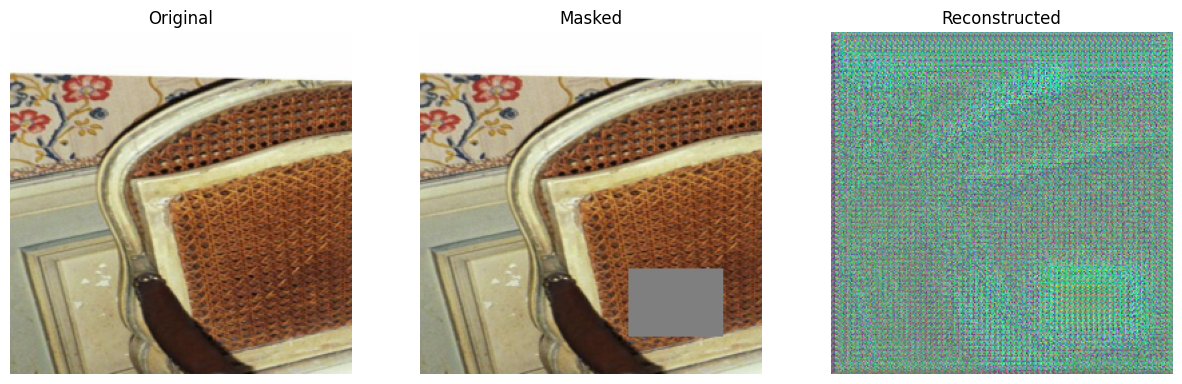

Saving visualization for epoch 0, batch 50


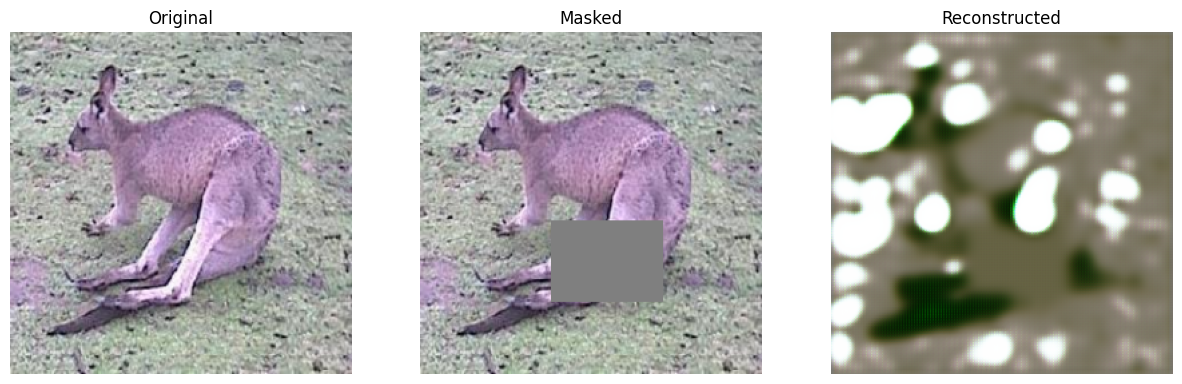

Saving visualization for epoch 0, batch 100


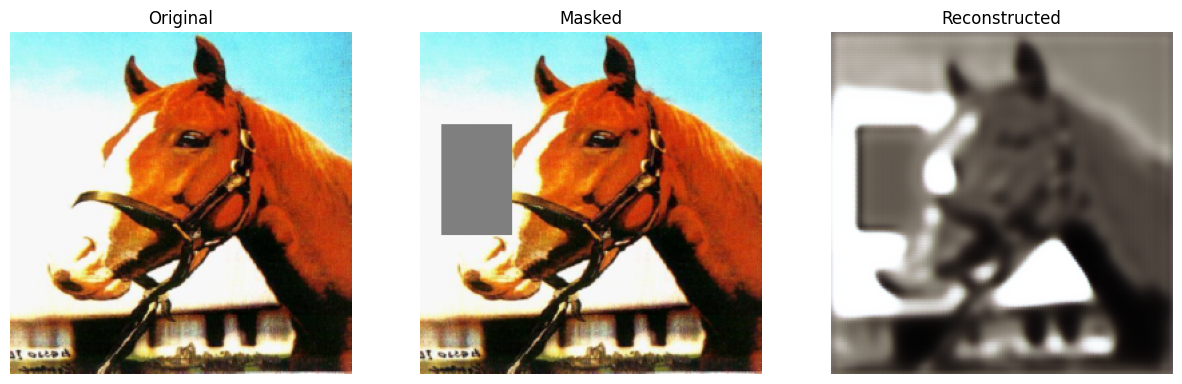

Saving visualization for epoch 0, batch 150


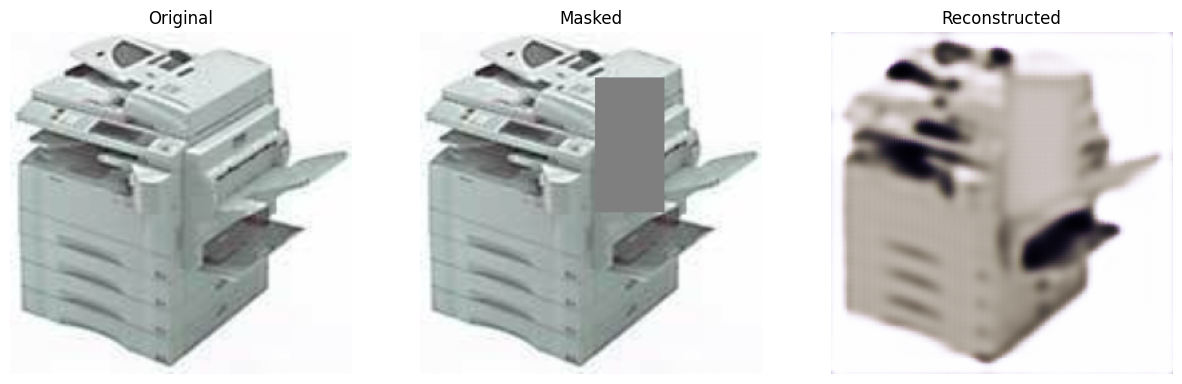

Saving visualization for epoch 0, batch 200


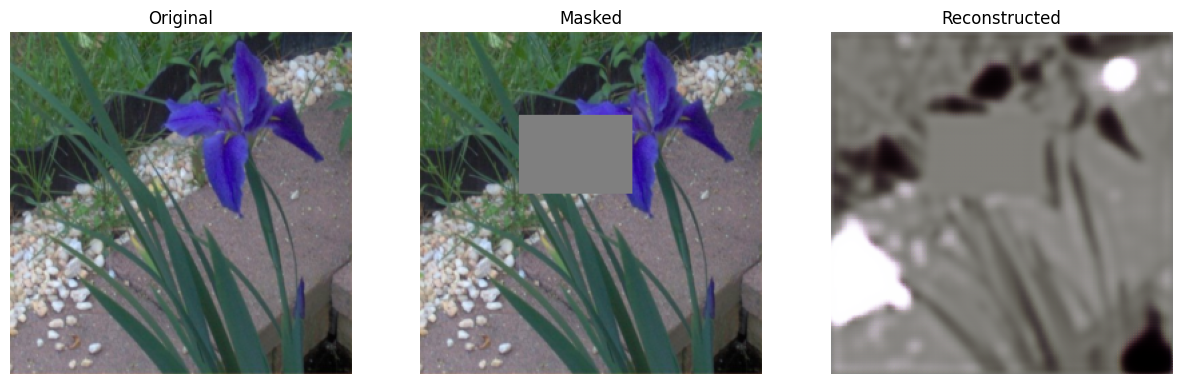

Saving visualization for epoch 0, batch 250


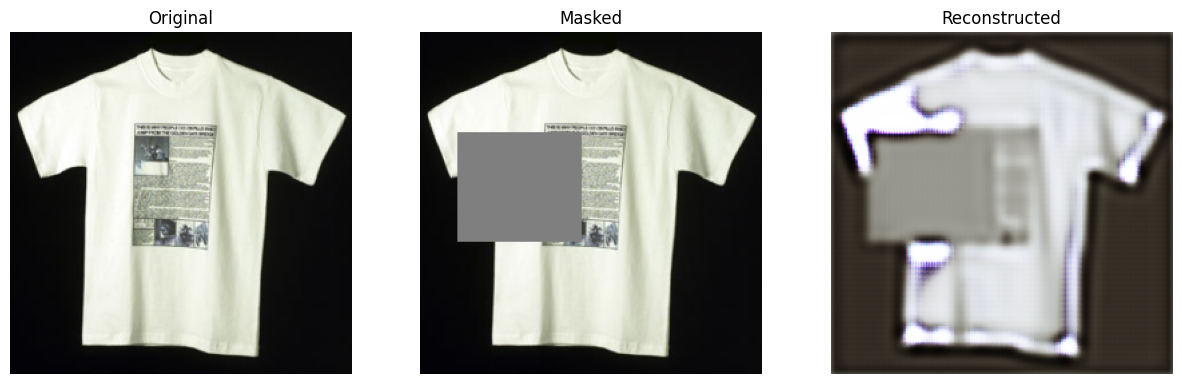

Saving visualization for epoch 0, batch 300


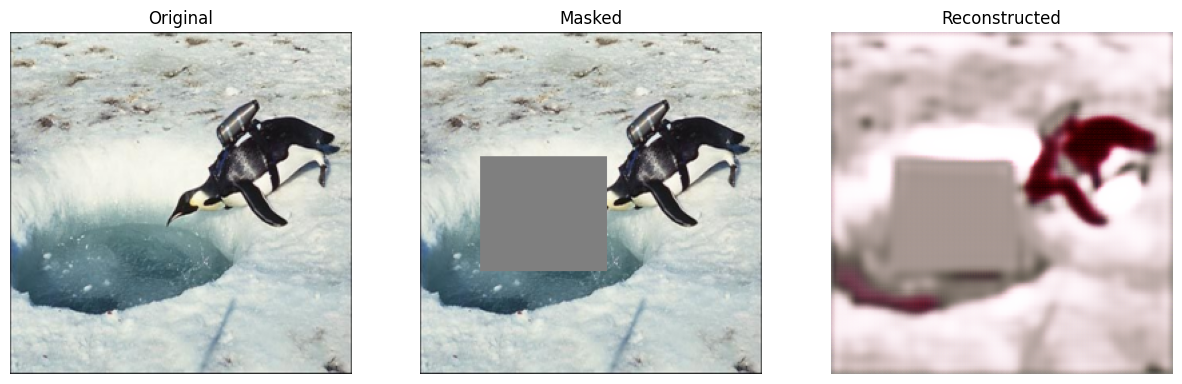

Saving visualization for epoch 0, batch 350


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torchvision import transforms
import os
import kagglehub
from google.colab import drive
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Create visualization directory
os.makedirs('visualization', exist_ok=True)

def train_model(model, train_loader, val_loader, num_epochs=10, device='cuda'):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.L1Loss()

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0

        for batch_idx, (images, _) in enumerate(train_loader):
            images = images.to(device)

            # Create masks and masked images
            masks = create_random_mask(images).to(device)
            masked_images = images * masks

            # Forward pass
            outputs = model(masked_images, masks)
            loss = criterion(outputs, images)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Visualize every 50 batches
            if batch_idx % 50 == 0:
                print(f"Saving visualization for epoch {epoch}, batch {batch_idx}")
                visualize_batch(images, masked_images, outputs, epoch, batch_idx)

                # Display a sample in Colab notebook
                plt.figure(figsize=(15, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(images[0].cpu().detach().numpy().transpose(1, 2, 0) * 0.5 + 0.5)
                plt.title('Original')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(masked_images[0].cpu().detach().numpy().transpose(1, 2, 0) * 0.5 + 0.5)
                plt.title('Masked')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(outputs[0].cpu().detach().numpy().transpose(1, 2, 0) * 0.5 + 0.5)
                plt.title('Reconstructed')
                plt.axis('off')

                plt.show()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)
                masks = create_random_mask(images).to(device)
                masked_images = images * masks
                outputs = model(masked_images, masks)
                loss = criterion(outputs, images)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Plot and save losses
        plot_losses(train_losses, val_losses)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        # Save model checkpoint
        torch.save(model.state_dict(), f'/content/drive/MyDrive/ckpts/model_epoch_{epoch}.pth')

def main():
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Setup data
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Download and setup dataset
    base_path = kagglehub.dataset_download("jessicali9530/caltech256")
    image_dir = os.path.join(base_path, '256_ObjectCategories')

    # Create dataset and loaders
    dataset = datasets.ImageFolder(root=image_dir, transform=transform)

    # Split dataset
    train_size = int(0.7 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

    # Create model
    model = InpaintingNet()

    # Train model
    train_model(model, train_loader, val_loader, num_epochs=10, device=device)

if __name__ == "__main__":
    main()